# Introduction

In these labs we will work with HMMs in the form of Weighted Finite State Transducers.    We will use the Python interface to the [OpenFst toolkit](http://openfst.org). Examples were given at the start of Lecture 5, but if you need a refresh, read this [introduction](https://github.com/geoph9/asr-labs/blob/main/introduction.pdf).

See [README.md](https://github.com/geoph9/asr-labs/blob/main/README.md) for lab setup instructions.

Although most of the lab instructions are self-contained, we have created our [own documentation](https://openfst-python-documentation.readthedocs.io/en/latest/index.html) to the Python interface to OpenFst, following feedback that the [official documentation](https://www.openfst.org/twiki/bin/view/FST/PythonExtension) is incomplete and hard to follow.  This may be useful as reference material if you want to understand the Python interface more fully.

# Getting started

We start by importing the OpenFst Python wrapper:

In [1]:
import openfst_python as fst

OpenFst internally stores FST labels in integer format. This means we need a _symbol table_ to map from the text form of the labels to their integer IDs.  We create now tables for our symbols.

A **SymbolTable()** is simply a table associating symbols and indexes. We add symbols to the table with the method **add_symbol()**

In [2]:
# Create two symbol tables: one for the input labels, one for the output labels
input_sym = fst.SymbolTable()
output_sym = fst.SymbolTable()

# input symbols
input_sym.add_symbol('<eps>') # by convention, <eps> always
                              # has symbol zero
input_sym.add_symbol('a')     
input_sym.add_symbol('b')

# output symbols
output_sym.add_symbol('<eps>') 
output_sym.add_symbol('d')
output_sym.add_symbol('c')

2

Now that we've got our symbol tables, we will build the FST itself:

In [3]:
f = fst.Fst()

f.set_input_symbols(input_sym)
f.set_output_symbols(output_sym)

Now, let's add some states:

In [4]:
s0 = f.add_state()
s1 = f.add_state()
s2 = f.add_state()
s3 = f.add_state()

The output of the **add_state()** method is just the index assigned to the state.  It's not necessary to store this, but in this example, we assign each state index to a variable name so that it can be easily used later.

To create arcs between states, we do:

In [5]:
# Get IDs for labels 'a', 'b', 'c', 'd' in integer form
a = input_sym.find('a')
b = input_sym.find('b')
c = output_sym.find('c')
d = output_sym.find('d')

# Add arcs
f.add_arc(s0, fst.Arc(a, c, None, s1))
f.add_arc(s0, fst.Arc(b, d, None, s2))
f.add_arc(s1, fst.Arc(a, c, None, s3))
f.add_arc(s2, fst.Arc(b, d, None, s3))

The syntax for the method **add_arc** is:

**add_arc(*source state*, *arc to add*)**

while the syntax for initializing a class **Arc()** is:

**Arc(*input symbol index*, *output symbol index*, *weight*, *destination state*)**

We use the **find()** method of the symbol tables to get the index of a label in the state table.

To finish constructing the FST we just add start and end states:

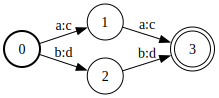

In [6]:
f.set_start(s0)
f.set_final(s3)

And our first FST, shown in the example above, is done!

# Exercises

In this lab you will build some simple FSTs.  Some of these will be related to words or phones, as described in lectures.  For these examples, we'll use a short _lexicon_ (a dictionary of pronunciations).  We load this from the provided text file with this helper function:

In [7]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

In [8]:
lex = parse_lexicon('lexicon.txt')
lex

{'a': ['ey'],
 'cat': ['k', 'ae', 't'],
 'of': ['ah', 'v'],
 'peck': ['p', 'eh', 'k'],
 'peppers': ['p', 'eh', 'p', 'er', 'z'],
 'peter': ['p', 'iy', 't', 'er'],
 'picked': ['p', 'ih', 'k', 't'],
 'pickled': ['p', 'ih', 'k', 'ah', 'l', 'd'],
 'piper': ['p', 'ay', 'p', 'er'],
 'the': ['dh', 'iy'],
 "where's": ['w', 'eh', 'r', 'z']}

1. Complete the following function that generates symbol tables from a lexicon, using the provided phonetic dictionary in **lexicon.txt** and the helper function *parse_lexicon* in cells above. Use p_1, p_2, ..., eh_1, ... to denote the phone state labels. 

In [9]:
def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))

    return word_table, phone_table, state_table

**You may check your answer with the codes below, where you can see the expected results and change your codes accordingly.**

In [10]:
word_table, phone_table, state_table = generate_symbol_tables(lex)

In [11]:
# Checking word_table
word_table.write_text('tmp.txt')
print(open('tmp.txt').read())

<eps>	0
a	1
cat	2
of	3
peck	4
peppers	5
peter	6
picked	7
pickled	8
piper	9
the	10
where's	11



In [12]:
# Checking phone_table
phone_table.write_text('tmp.txt')
print(open('tmp.txt').read())

<eps>	0
ey	1
k	2
ae	3
t	4
ah	5
v	6
p	7
eh	8
er	9
z	10
iy	11
ih	12
l	13
d	14
ay	15
dh	16
w	17
r	18



In [13]:
# Checking state_table
state_table.write_text('tmp.txt')
print(open('tmp.txt').read())

<eps>	0
ey_1	1
ey_2	2
ey_3	3
k_1	4
k_2	5
k_3	6
ae_1	7
ae_2	8
ae_3	9
t_1	10
t_2	11
t_3	12
ah_1	13
ah_2	14
ah_3	15
v_1	16
v_2	17
v_3	18
p_1	19
p_2	20
p_3	21
eh_1	22
eh_2	23
eh_3	24
er_1	25
er_2	26
er_3	27
z_1	28
z_2	29
z_3	30
iy_1	31
iy_2	32
iy_3	33
ih_1	34
ih_2	35
ih_3	36
l_1	37
l_2	38
l_3	39
d_1	40
d_2	41
d_3	42
ay_1	43
ay_2	44
ay_3	45
dh_1	46
dh_2	47
dh_3	48
w_1	49
w_2	50
w_3	51
r_1	52
r_2	53
r_3	54



2. Create functions generating WFSTs representing the following HMMs (illustrated in Lecture 4, slide 11)

    1. A 3-state left-to-right phone HMM with self-loops
    2. A 5-state parallel-path left-to-right HMM
    3. An ergodic HMM with $n$ states (you will need to think about how to handle initial and final states)
    
Don't worry about the arc labels for the second two WFSTs.  

In [14]:
def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, None, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        f.add_arc(current_state, fst.Arc(in_label, out_label, None, next_state))    
       
        current_state = next_state
        
    return current_state




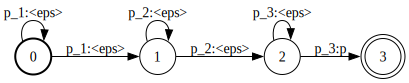

In [15]:
# Here is the code to help you debug your solutions
f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_phone_wfst(f, start, 'p', 3)
f.set_final(last_state)

f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

In [16]:
def generate_parallel_path_wfst(f, start_state, n):
    """
    Generate a WFST representing an n-state parallel-path left-to-right HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    next_state = f.add_state()
    for i in range(n):
    
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(0, 0, None, current_state))
        f.add_arc(current_state, fst.Arc(0, 0, None, next_state))
        if i != n-1:
            next_next_state = f.add_state()
            f.add_arc(current_state, fst.Arc(0, 0, None, next_next_state))
        current_state = next_state
        next_state = next_next_state
    
    f.add_arc(current_state, fst.Arc(0, 0, None, current_state)) # self-loop for the last state
    f.set_final(current_state)
    return current_state




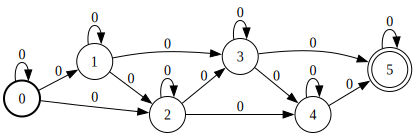

In [17]:
# Here is the code to help you debug your solutions
f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_parallel_path_wfst(f, start, 5)
f

In [18]:
def generate_ergodic_wfst(f, start_state, n):
    """
    Generate a WFST representing an n-state ergodic HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """    
    
    current_state = start_state
    
    for i in range(n):
        
        f.add_state()
        f.set_final(i+1) # +1 to skip the start state
        
    for i in range(n+1): # +1 is start state
        for j in range(n+1):
            f.add_arc(i, fst.Arc(0, 0, None, j))

    return current_state

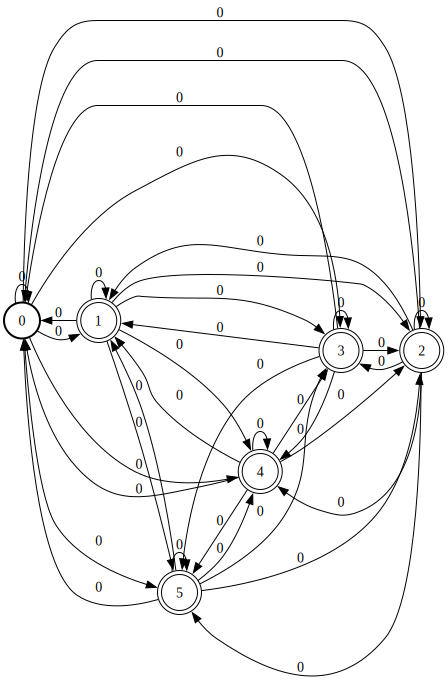

In [19]:
# Here is the code to help you debug your solutions
f = fst.Fst()
start = f.add_state()
f.set_start(start)

last_state = generate_ergodic_wfst(f, start, 5)
f

3. Write a function to generate an HMM for any word in the lexicon using $n$ states per phone by concatenating $n$-state phone HMMs. Make use of your *generate_phone_wfst()* function. 

In [20]:
def generate_word_wfst(f, start_state, word, n):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.  
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """

    current_state = start_state
    
    # iterate over all the phones in the word
    for phone in lex[word]:   # will raise an exception if word is not in the lexicon
        # your code here
        
        current_state = generate_phone_wfst(f, current_state, phone, n)
    
        # note: new current_state is now set to the final state of the previous phone WFST
        
    f.set_final(current_state)
    
    return f



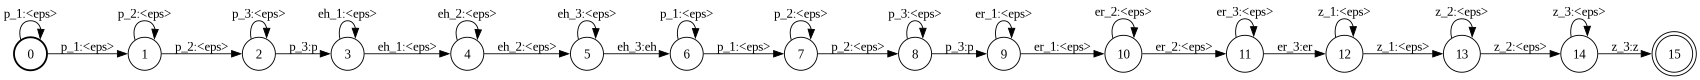

In [21]:
# Here is the code to help you debug your solutions
f = fst.Fst()
start = f.add_state()
f.set_start(start)

generate_word_wfst(f, start, 'peppers', 3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

4. Generate an HMM that can recognise:

    1. any phone contained in the lexicon
    2. any sequence of phones contained in the lexicon
    
Think of the difference between the first and the second HMM. Again, previous functions should help in the task. 

In [22]:
def generate_phone_recognition_wfst(n):
    """ generate a HMM to recognise any single phone in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    # get a list of all the phones in the lexicon
    # there are lots of way to do this.  Here, we use the set() object

    # will contain all unique phones in the lexicon
    phone_set = set()
    
    for pronunciation in lex.values():
        phone_set = phone_set.union(pronunciation)
        
    for phone in phone_set:
        
        # we need to add an empty arc from the start state to where the actual phone HMM
        # will begin.  If you can't see why this is needed, try without it!
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
    
        end_state = generate_phone_wfst(f, current_state, phone, n)
    
        f.set_final(end_state)
            
    return f




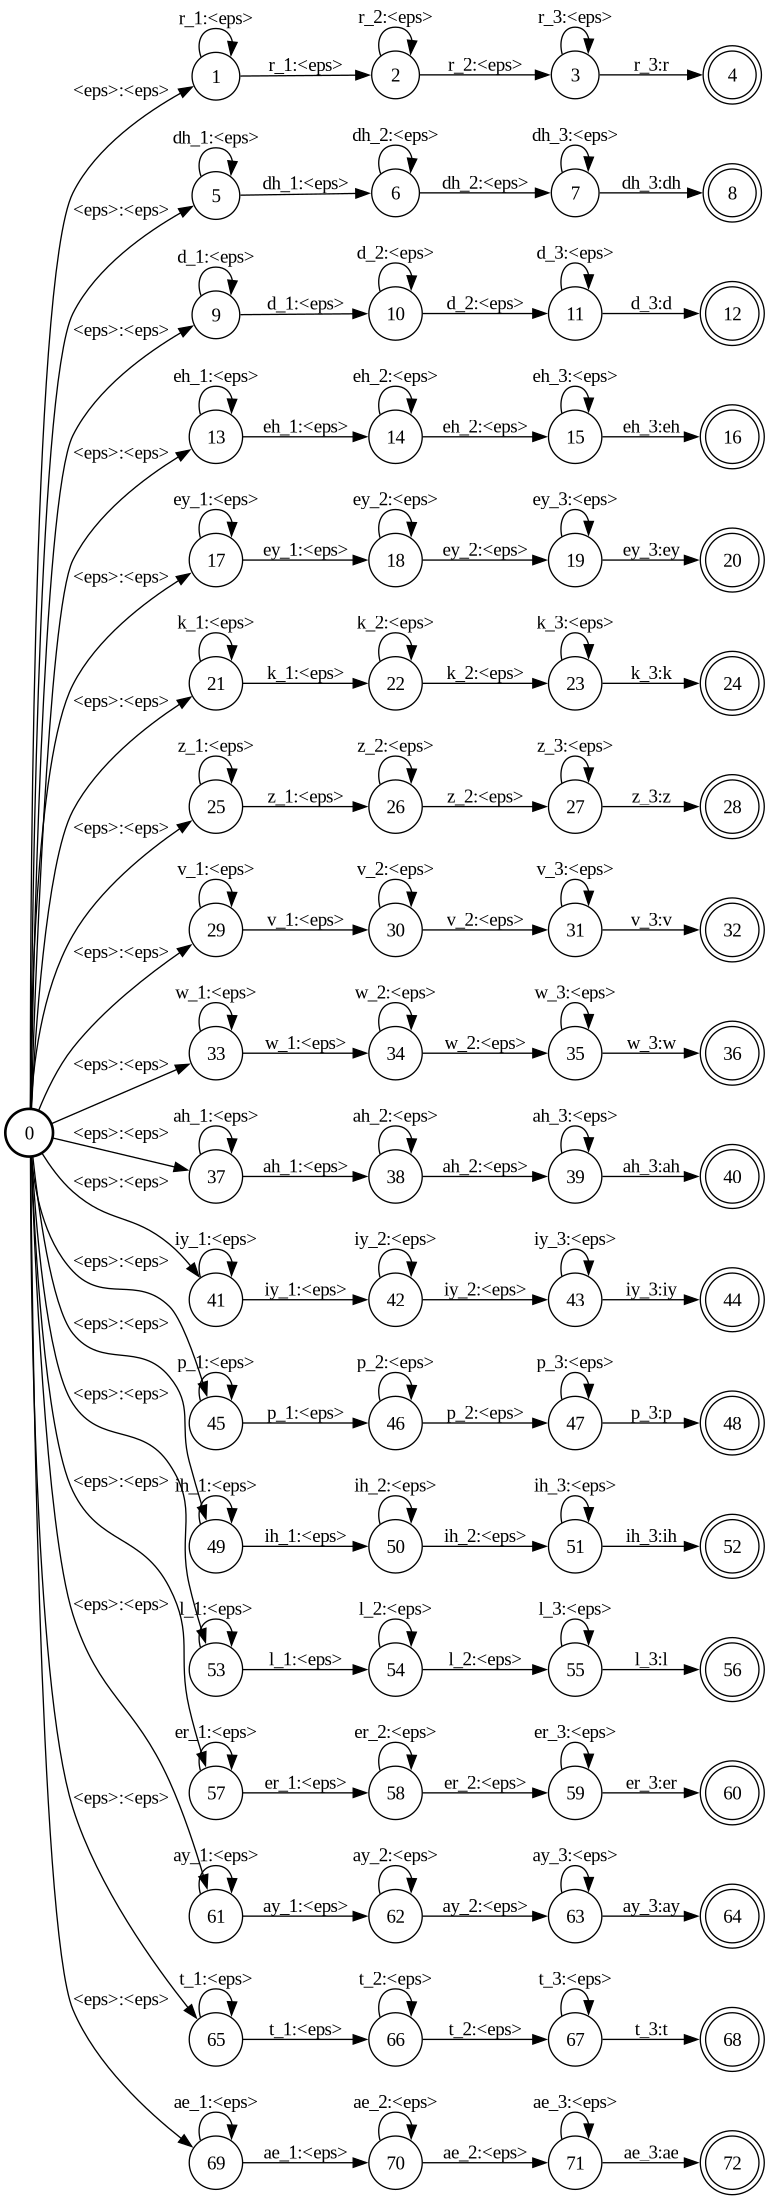

In [23]:
# Here is the code to help you debug your solutions
f = generate_phone_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [24]:
def generate_phone_sequence_recognition_wfst(n):
    """ generate a HMM to recognise any single phone sequence in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    phone_set = set()
    
    for pronunciation in lex.values():
        phone_set = phone_set.union(pronunciation)
        
    for phone in phone_set:
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
    
        end_state = generate_phone_wfst(f, current_state, phone, n)
        
        f.add_arc(end_state, fst.Arc(0,0, None, start_state))
        f.set_final(end_state)
            
    return f



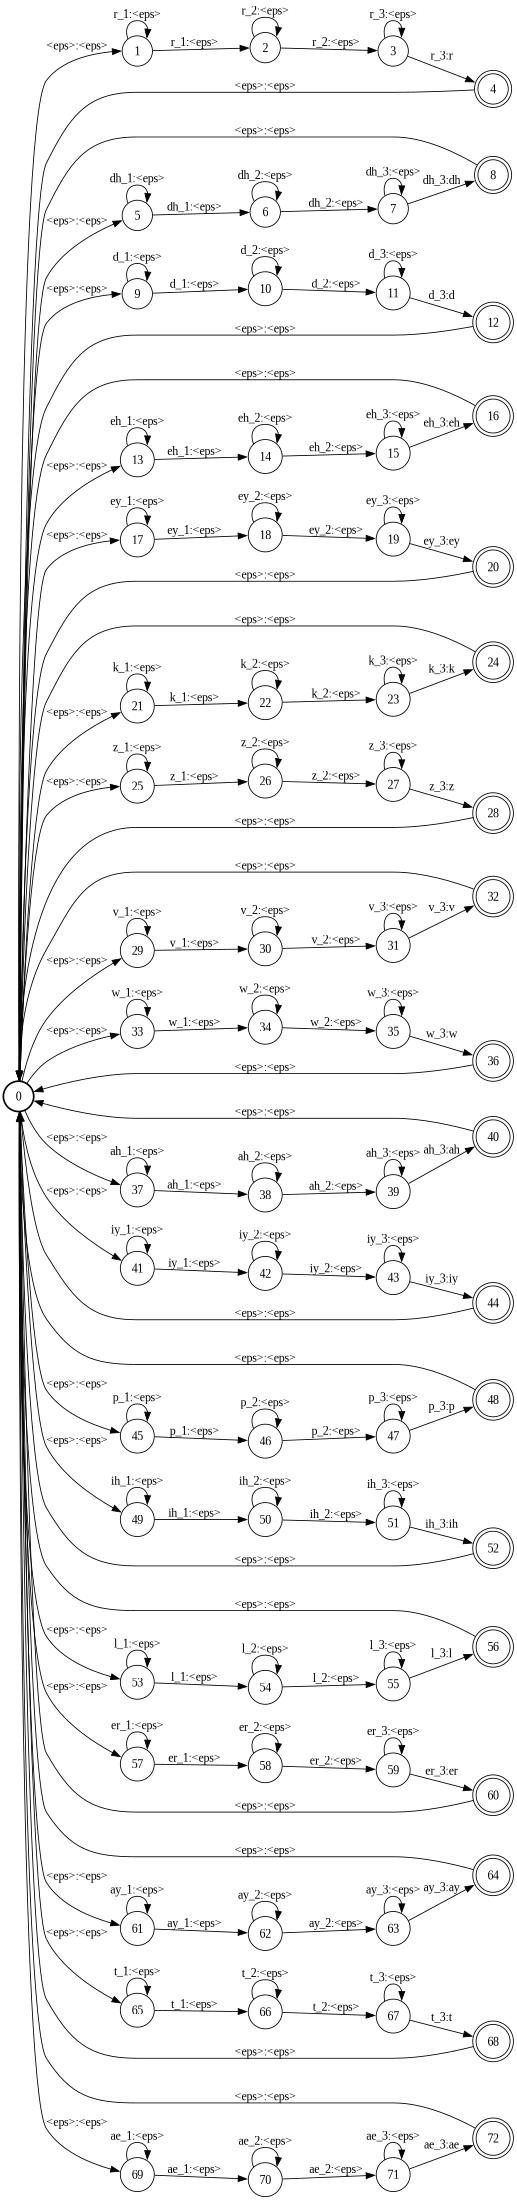

In [25]:
# Here is the code to help you debug your solutions
f = generate_phone_sequence_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

5. You have decided that the best way to start teaching a friend English is to have them learn the notorious tongue-twister *peter piper picked a peck of pickled peppers*.  Write a function that creates an HMM that can recognize any sequence of these words.

In [26]:
def generate_word_sequence_recognition_wfst(n):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst()
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    
    for word, phones in lex.items():
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        f.set_final(current_state)
        f.add_arc(current_state, fst.Arc(0, 0, None, start_state))
        
    return f



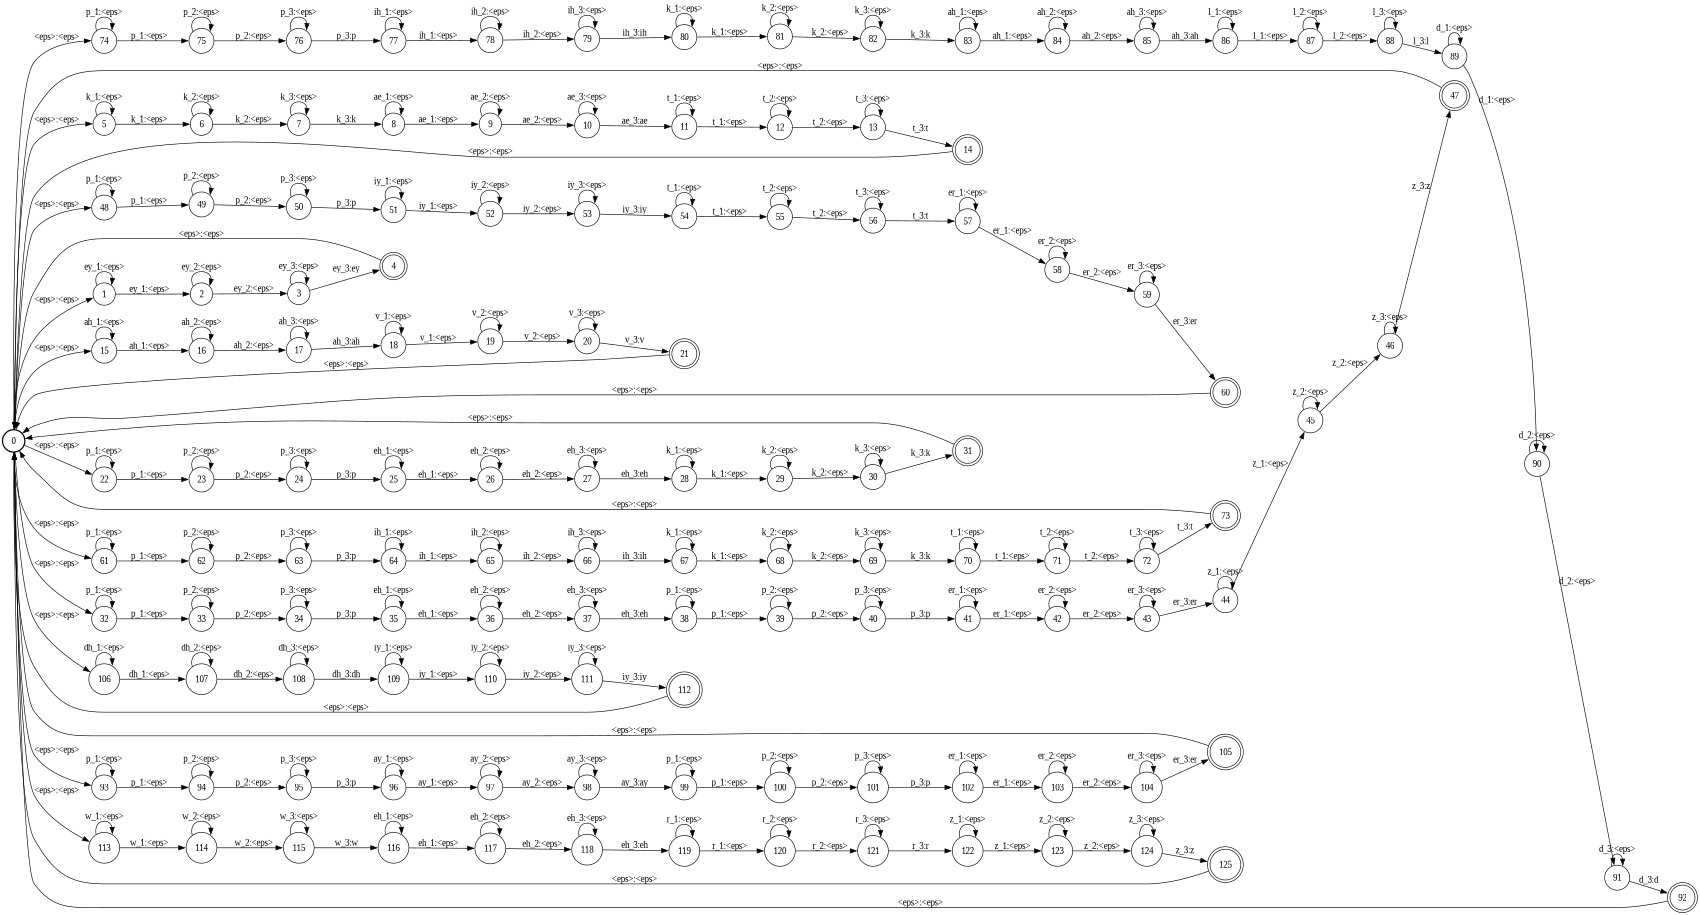

In [27]:
# Here is the code to help you debug your solutions
f = generate_word_sequence_recognition_wfst(3)
f.set_input_symbols(state_table)
f.set_output_symbols(phone_table)

from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

# If you have more time (optional)

Probabilities in WFSTs are traditionally expressed in negative log format, that is, the weight $w$ on an arc transitioning between states $i$ and $j$ is given by $w=-\log a_{ij}$, where $a_{ij}$ is the HMM transition probability.

6. Add weights to your WFSTs corresponding to transition probabilities.  Assume that the probability of a self-loop is $0.1$, and that when transitioning *between* separate phones or words, the probabilities are uniform over all transitions.